In [1]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878)

# data (as pandas dataframes)
X = cirrhosis_patient_survival_prediction.data.features
y = cirrhosis_patient_survival_prediction.data.targets

# metadata
print(cirrhosis_patient_survival_prediction.metadata)

# variable information
print(cirrhosis_patient_survival_prediction.variables)


{'uci_id': 878, 'name': 'Cirrhosis Patient Survival Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1', 'data_url': 'https://archive.ics.uci.edu/static/public/878/data.csv', 'abstract': 'Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 418, 'num_features': 17, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Age', 'Sex'], 'target_col': ['Status'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5R02G', 'creators': ['E. Dickson', 'P. Grambsch', 'T. Fleming', 'L. Fisher', 'A. Langworthy'], 'intro_paper': {'ID': 296, 'type'

In [6]:
# --------------------------------------------
# PREPROCESAMIENTO CORRECTO PARA PBC — GOOGLE COLAB
# --------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

# 1) Carga del dataset
pbc = fetch_ucirepo(id=878)
df  = pd.concat([pbc.data.features, pbc.data.targets], axis=1)

TARGET = "Stage"
df = df.dropna(subset=[TARGET])          # nos aseguramos de no tener NAs en la variable objetivo
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

In [7]:
# 2) Definir columnas numéricas y categóricas
num_cols  = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols  = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numéricas  : {num_cols}")
print(f"Categóricas: {cat_cols}")


Numéricas  : ['Age', 'Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT', 'Prothrombin']
Categóricas: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Cholesterol', 'Copper', 'Tryglicerides', 'Platelets', 'Status']


In [8]:

# 3) Construir el preprocesador: escalar numéricas y one-hot en categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# 4) Dividir datos y transformar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train_p = preprocessor.fit_transform(X_train)
X_test_p  = preprocessor.transform(X_test)


=== Árbol de decisión para 'Status' ===
Accuracy: 0.6571428571428571
              precision    recall  f1-score   support

           C       0.68      0.71      0.69        58
          CL       0.00      0.00      0.00         6
           D       0.62      0.68      0.65        41

    accuracy                           0.66       105
   macro avg       0.44      0.46      0.45       105
weighted avg       0.62      0.66      0.64       105



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


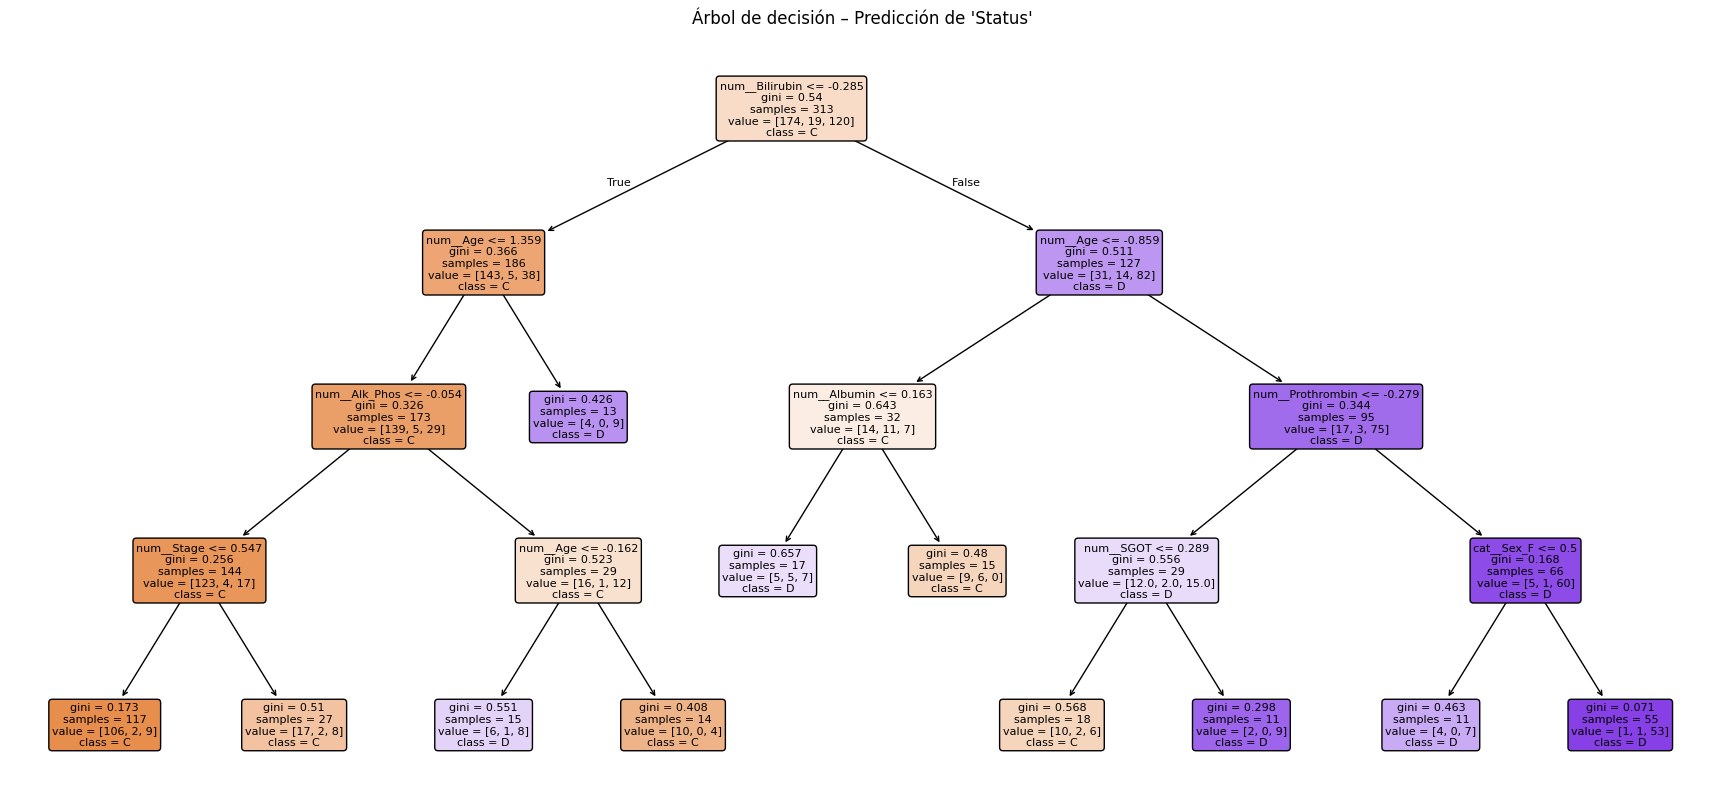

In [14]:
# --------------------------------------------
# PREPROCESAMIENTO ROBUSTO: IMPUTAR + ESCALAR + ONE-HOT
# Objetivo: predecir la variable **Status**
# --------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

# 1) Cargar y ensamblar el dataset
pbc = fetch_ucirepo(id=878)
df  = pd.concat([pbc.data.features, pbc.data.targets], axis=1)

TARGET = "Status"               # ← nueva variable a predecir
df = df.dropna(subset=[TARGET]) # elimina registros sin Status

# 1.1) Asegurarse de que y sea numérica
if df[TARGET].dtype == "object":
    le = LabelEncoder()
    y = le.fit_transform(df[TARGET])
    class_names = le.classes_.astype(str)
else:
    y = df[TARGET].astype(int).values
    class_names = np.sort(np.unique(y)).astype(str)

X = df.drop(columns=[TARGET])

# 2) Columnas numéricas y categóricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# 3) Pipelines de preprocesamiento
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# 4) División y transformación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train_p = preprocessor.fit_transform(X_train)
X_test_p  = preprocessor.transform(X_test)

# 5) Entrenar árbol de decisión
tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=10,
    random_state=42
)
tree.fit(X_train_p, y_train)

# 6) Evaluación
print("=== Árbol de decisión para 'Status' ===")
print("Accuracy:", accuracy_score(y_test, tree.predict(X_test_p)))
print(classification_report(y_test, tree.predict(X_test_p), target_names=class_names))

# 7) Visualización
plt.figure(figsize=(22, 10))
plot_tree(
    tree,
    feature_names=preprocessor.get_feature_names_out(),
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Árbol de decisión – Predicción de 'Status'")
plt.show()
